# Supervised learning using predictive coding

This notebook illustrates how the predictive coding library can be used to train a predictive coding network on a supervised learning task (MNIST).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bogacz-Group/PredictiveCoding/blob/main/1_supervised_learning_pc.ipynb)

In [15]:
# import pc library of the code is being run on google colab
try:
  import google.colab
  !git clone https://github.com/Bogacz-Group/PredictiveCoding.git
  ! cp -r PredictiveCoding/predictive_coding predictive_coding 
except ImportError:
  pass

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy 

import predictive_coding as pc

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


In [17]:
# load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transform)

batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'# train images: {len(train_dataset)} and # test images: {len(test_dataset)}')

# train images: 60000 and # test images: 10000


### Defining a model
A model can be initalised in the same way as pytorch model, with the addition of `pc.PCLayer()` to include latent variables in the model. 

A `PCLayer()` contains the activities of a layer of latent variables under `pclayer._x`. A `PCLayer()` also contains the energy associated with that activity under `pclayer._energy` which is computed with `0.5 *(inputs['mu'] - inputs['x'])**2` where `inputs['x']` is the activity of that layer and `inputs['mu']` is the input to that layer. 

Check out the `PCLayer()` class in `predictive_coding/pc_layer.py` for more information.

In [18]:
input_size = 28*28  # 28x28 images
hidden_size = 256
output_size = 10    # 10 classes
activation_fn = nn.ReLU
loss_fn = lambda output, _target: 0.5 * (output - _target).pow(2).sum() # this loss function holds to the error of the output layer of the model


model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    pc.PCLayer(),
    activation_fn(),
    nn.Linear(hidden_size, hidden_size),
    pc.PCLayer(),
    activation_fn(),
    nn.Linear(hidden_size, output_size)
)
model.train()   # set the model to training mode
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): PCLayer()
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): PCLayer()
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

### Defining a model trainer
The predictive coding library is based around a `pc.PCTrainer()`. 

This trainer orchestrate the activity and parameter updates of the model to minimise the total error of the model. The total error is given by the sum of the energies in each pclayer as well as the loss functions. 

In [19]:
# number of inference iterations where the latent states x are updated. Inference does not run till convergence but for a fixed number of iterations
T = 20                              

# options for the update of the latent state x
optimizer_x_fn = optim.SGD          # optimizer for latent state x, SGD perform gradient descent. Other alternative are Adam, RMSprop, etc. 
optimizer_x_kwargs = {'lr': 0.01}   # optimizer parameters for latent state x to pass to the optimizer. The best learning rate will depend on the task and the optimiser. 
                                    # Other parameters such as momentum, weight_decay could also be set here with additional elements, e.g., "momentum": 0.9, "weight_decay": 0.01

# options for the update of the parameters p
update_p_at = 'last'                # update parameters p at the last iteration, can be set to 'all' to implement ipc (https://arxiv.org/abs/2212.00720)
optimizer_p_fn = optim.Adam         # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.001}  # optimizer parameters for parameters p, 0.001 is a good starting point for Adam, but it should be adjusted for the task

trainer = pc.PCTrainer(model, 
    T = T, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
)

In [20]:
# get classification accuracy of the model
def test(model, dataset, batch_size=1000):
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        _, predicted = torch.max(pred, -1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    model.train()
    return round(correct / total, 4)

### Train the model
`trainer.train_on_batch()` is called for each batch of data. This function updates the activity of the latent states and the parameters for the given batch of data. 

Epoch 10 - Test accuracy: 0.983: 100%|██████████| 120/120 [00:11<00:00, 10.88it/s]


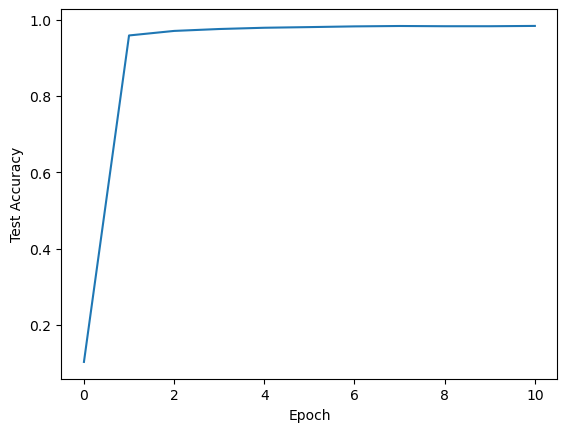

In [21]:
epochs = 10

test_acc = np.zeros(epochs + 1)
test_acc[0] = test(model, test_dataset)
for epoch in range(epochs):
    # Initialize the tqdm progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch+1} - Test accuracy: {test_acc[epoch]:.3f}') as pbar:
        for data, label in pbar:
            data, label = data.to(device), label.to(device)
            # convert labels to one-hot encoding
            label = F.one_hot(label, num_classes=output_size).float()
            trainer.train_on_batch(
                inputs=data,
                loss_fn=loss_fn,
                loss_fn_kwargs={'_target': label}
            )    
    test_acc[epoch + 1] = test(model, test_dataset)
    pbar.set_description(f'Epoch {epoch + 1} - Test accuracy: {test_acc[epoch + 1]:.3f}')

plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()

The trained model achieves a classification accuracy of above 95% on MNIST which is comparable to a backpropagation trained model with the same architecture.